## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import seaborn as sns
from random import sample

from itertools import chain
from random import sample 
import scipy

import tensorflow as tf
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
6451,00001736_005.png,No Finding,5,1736,32,F,AP,2500,2048,0.168,0.168,NaN,/data/images_002/images/00001736_005.png
54004,00013615_015.png,No Finding,15,13615,10,F,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00013615_015.png
48429,00012280_001.png,No Finding,1,12280,52,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00012280_001.png


In [3]:
def replace_pneumonia(row):
    if 'pneumonia' in row['Finding Labels'].lower():
        return 'present' 
    else:
        return 'absent'
all_xray_df['Pneumonia'] = all_xray_df.apply (lambda row: replace_pneumonia(row), axis=1)
all_xray_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Pneumonia
90757,00022600_001.png,Pleural_Thickening,1,22600,67,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00022600_001.png,absent
94217,00024013_000.png,No Finding,0,24013,21,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00024013_000.png,absent
23826,00006283_000.png,No Finding,0,6283,46,M,PA,2500,2048,0.171,0.171,NaN,/data/images_003/images/00006283_000.png,absent


In [4]:
all_xray_df['Pneumonia'] = all_xray_df['Pneumonia'].astype(str)
print(all_xray_df['Pneumonia'].dtypes)

object


## Create your training and testing data:

In [5]:
#def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
train_data, val_data = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Pneumonia'])
    #return train_data, val_data

In [6]:
print(train_data[:3])
print(type(train_data))

             Image Index          Finding Labels  Follow-up #  Patient ID  \
108986  00029596_008.png  Consolidation|Effusion            8       29596   
1901    00000492_000.png                Fibrosis            0         492   
101189  00026867_005.png              No Finding            5       26867   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
108986           34              F            AP                 2544   
1901             53              F            PA                 2454   
101189           32              F            AP                 2645   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
108986     3056                        0.139  0.139          NaN   
1901       2705                        0.143  0.143          NaN   
101189     2544                        0.139  0.139          NaN   

                                            path Pneumonia  
108986  /data/images_012/images/00029596_008.png    absent  
190

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
image_size=(224,224)

In [8]:

my_train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.5)
   

train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'binary',
                                         target_size = image_size, 
                                         batch_size = 100
                                         )

    

my_val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

val_gen = my_val_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'binary',
                                         target_size = image_size, 
                                         batch_size = 10)



Found 89696 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.


In [9]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()
print(valX[0].shape)

(224, 224, 3)


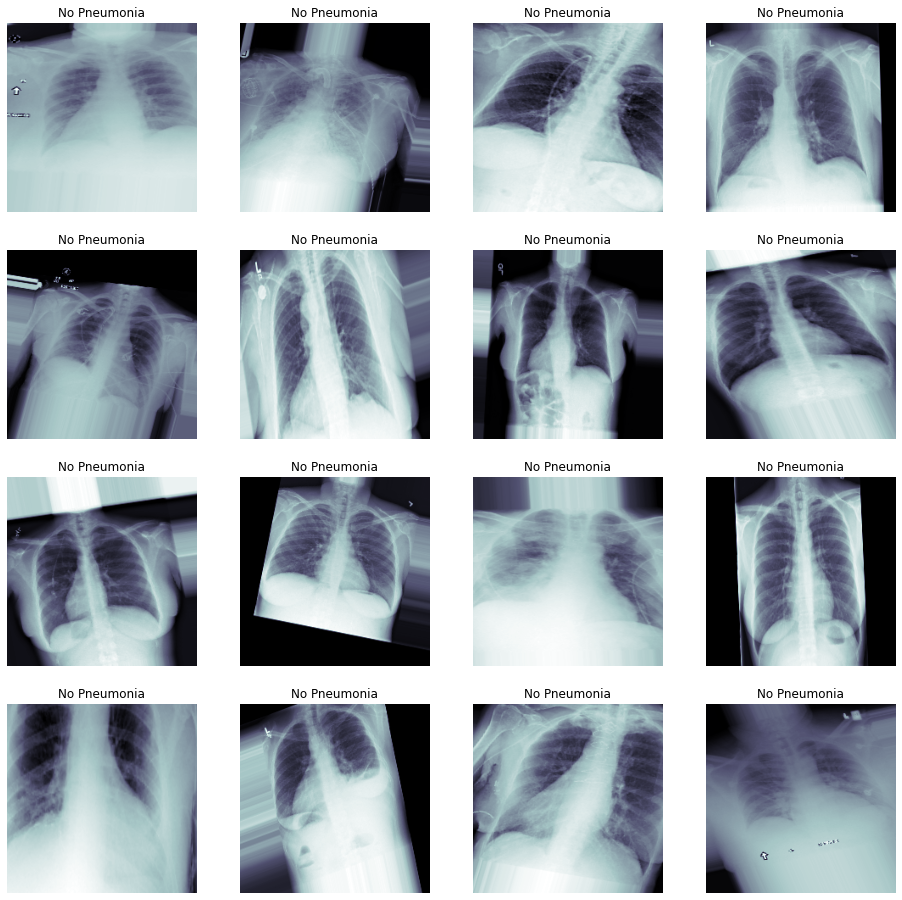

In [10]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [11]:
model1 = VGG16(include_top=False, weights='imagenet')
flatten = Flatten()
n1 = Dense(10, activation='sigmoid')


58892288/58889256 [==============================] - 1s 0us/step


In [12]:
#def load_pretrained_model(vargs):
    
model = VGG16(include_top=True, weights='imagenet')
model.summary()   
    # Todo
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    #return vgg_model


553467904/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [13]:

my_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
my_model.add(vgg_model) #vgg_model

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
my_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
my_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
my_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
my_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
my_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
my_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
my_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
my_model.add(Dense(1, activation='sigmoid'))


#freeze the all the CNN layers except for the last one
for layer in vgg_model.layers[0:17]:
    layer.trainable = False
# 4. set optimizer, loss function, and metrics to monitor
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']    
    

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [14]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [17]:
my_model.fit_generator(train_gen, 
                        validation_data = (valX, valY), 
                                 epochs = 1)

In [18]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [19]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="my_model_best"


checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'xray_class', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'max',
                             save_weights_only = True)

early = EarlyStopping(monitor= 'xray_class', 
                      mode= max, 
                      patience=10)

callbacks_list = [checkpoint, early]
print(weight_path)

my_model_best


/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:788: RuntimeWarning: EarlyStopping mode <built-in function max> is unknown, fallback to auto mode.
  RuntimeWarning)


### Start training! 

In [20]:


history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 3, 
                          callbacks = callbacks_list)

Epoch 1/3
897/897 [==============================] - 2593s 3s/step - loss: 0.0741 - binary_accuracy: 0.9872 - val_loss: 0.0347 - val_binary_accuracy: 1.0000
Epoch 2/3


/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with xray_class available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `xray_class` which is not available. Available metrics are: val_loss,val_binary_accuracy,loss,binary_accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


897/897 [==============================] - 2818s 3s/step - loss: 0.0720 - binary_accuracy: 0.9872 - val_loss: 0.0195 - val_binary_accuracy: 1.0000
Epoch 3/3
897/897 [==============================] - 2575s 3s/step - loss: 0.0713 - binary_accuracy: 0.9872 - val_loss: 0.0591 - val_binary_accuracy: 1.0000


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [45]:
#checkpoint_path = "training/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [49]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
#weight_path = checkpoint_path
#my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)


10/10 [==============================] - 1s 50ms/step


In [60]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    
    c_ax.set_ylabel('True Positive Rate')
    
    
    
    return

## what other performance statistics do you want to include here besides AUC? 

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")    
  
    return history

In [61]:
valX, valY = next(val_gen)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

10/10 [==============================] - 0s 18ms/step


In [65]:
print(valY)
pred_Y.shape
#plot_auc(valY,pred_Y)




[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


(10, 1000)

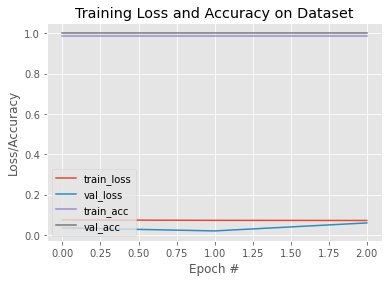

In [63]:
## plot figures

plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [24]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
# Todo

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

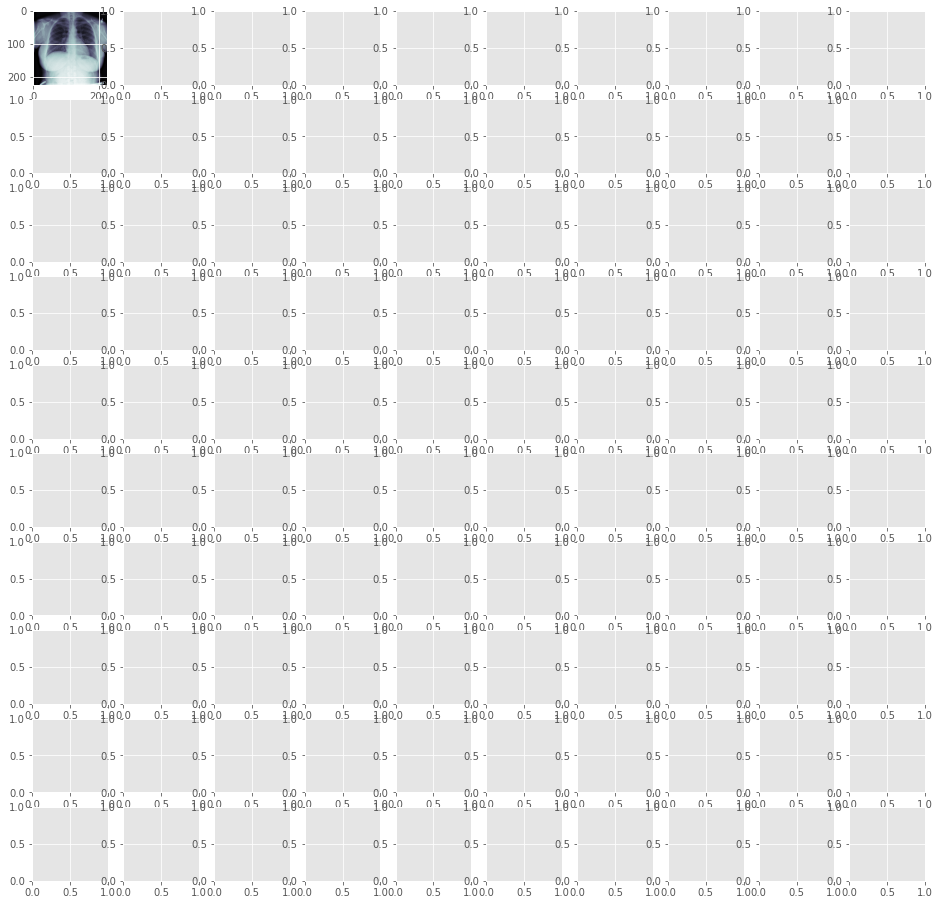

In [68]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

YOUR_THRESHOLD = 0.5
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], t_y[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [69]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)